<a href="https://colab.research.google.com/github/hkoenicke/UCDPA_HeikeKoenicke/blob/main/WeatherData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Import packages

import requests
from bs4 import BeautifulSoup
import re
from urllib.request import urlopen
from io import BytesIO
from zipfile import ZipFile
import fnmatch
import os.path
import datetime

# Data Analysis
import pandas as pd
import numpy as np

# Data Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
path_dwd = 'https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/daily/kl/'
url_weather_stations = path_dwd + 'historical/KL_Tageswerte_Beschreibung_Stationen.txt'



In [4]:
# read information about weather stations from the website into a pandas data frame
df_weather_stations = pd.DataFrame()
df_weather_stations = pd.read_fwf(url_weather_stations,
                               encoding='ISO-8859-1',
                               header=None,
                               skiprows=[0, 1],
                               names=['Station ID', 'First Date', 'Last Date',
                                   'Altitude', 'Latitude', 'Longitude',
                                   'Station Name', 'Federal State'])

# convert 'First Date' and 'Last Date' from int to datetime format
df_weather_stations[['First Date','Last Date']] = df_weather_stations[['First Date','Last Date']].apply(pd.to_datetime,format='%Y%m%d')

df_weather_stations.head()

,Station ID,First Date,Last Date,Altitude,Latitude,Longitude,Station Name,Federal State
0,1,1937-01-01,1986-06-30,478,47.8413,8.8493,Aach,Baden-Württemberg
1,3,1891-01-01,2011-03-31,202,50.7827,6.0941,Aachen,Nordrhein-Westfalen
2,11,1980-09-01,2020-09-30,680,47.9736,8.5205,Donaueschingen (Landeplatz),Baden-Württemberg
3,44,1969-01-01,2023-08-17,44,52.9336,8.2370,Großenkneten,Niedersachsen
4,52,1969-01-01,2001-12-31,46,53.6623,10.1990,Ahrensburg-Wulfsdorf,Schleswig-Holstein


In [5]:
df_weather_stations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1351 entries, 0 to 1350
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Station ID     1351 non-null   int64         
 1   First Date     1351 non-null   datetime64[ns]
 2   Last Date      1351 non-null   datetime64[ns]
 3   Altitude       1351 non-null   int64         
 4   Latitude       1351 non-null   float64       
 5   Longitude      1351 non-null   float64       
 6   Station Name   1351 non-null   object        
 7   Federal State  1351 non-null   object        
dtypes: datetime64[ns](2), float64(2), int64(2), object(2)
memory usage: 84.6+ KB


There are no missing values.

In [6]:
# Get list of all zip files for historic data

page_info = requests.get(path_dwd +'historical').text

# read file names using regular expression
files = re.findall(r"(?<=href=\")tageswerte_KL_[0-9]+_[0-9]+_\w*\.zip",page_info)

# get station ids using regular expression
station_ids = re.findall(r"(?<=href=\"tageswerte_KL_)[0-9]+",page_info)
# convert to int
station_ids = [int(x) for x in station_ids]

# convert the two lists into a dictionary
station_file_names = {}
station_file_names = {station_ids[i]: files[i] for i in range(len(station_ids))}

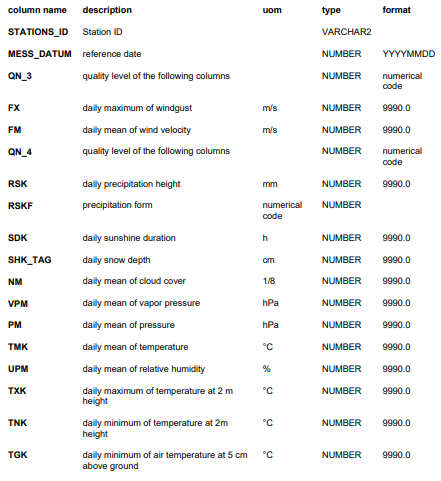

In [ ]:
# Process zip files

# create data list for climate data
weather_list =  []
for id in station_ids:
  for category in ['historical','recent']:
    if category == 'historical':
      url = path_dwd + 'historical/' + station_file_names[id]
    else:
      url = path_dwd + 'recent/tageswerte_KL_' + str(id).zfill(5) + '_akt.zip'

    try:
      # open zip file
      zf = ZipFile(BytesIO(urlopen(url).read()))

      # find csv file starting with 'produkt'
      csv_file_name = fnmatch.filter(zf.namelist(),'produkt*.txt')

      # open zipped csv file
      file_csv = zf.open(*csv_file_name)

      # read specific columns and append it to the weather list
      weather_list.append(pd.read_csv(file_csv,sep=';',usecols=['STATIONS_ID',
                                                                'MESS_DATUM',
                                                                '  FX',# daily max. windgust
                                                                '  FM',# daily mean wind velocity
                                                                ' RSK',# daily precipitation height
                                                                'RSKF',# precipitation form
                                                                ' SDK',# daily sunshine duration
                                                                'SHK_TAG',# daily snow depth
                                                                '  NM',# daily mean cloud cover
                                                                ' VPM',# daily mean vapor pressure
                                                                '  PM',# daily mean pressure
                                                                ' TMK',# daily mean temperature
                                                                ' UPM',# daily mean of relative humidity
                                                                ' TXK',# daily max. temperature at 2m height
                                                                ' TNK',# daily min. temperature at 2m height
                                                                ' TGK',# daily min. air temperature at 5cm above ground
                                                                'QN_3',# quality level FX & FM
                                                                'QN_4'],# quality level rest
                                      parse_dates=['MESS_DATUM']))

      # close txt.file and zip file
      file_csv.close()
      zf.close()

    except IOError: # ignore
      pass

# create pandas data frame with weather list
weather = pd.concat(weather_list)
# rename columns
weather = weather.rename(columns={'STATIONS_ID': 'Station ID',
                                  'MESS_DATUM': 'Date',
                                  '  FX': 'WindGustMax',
                                  '  FM': 'WindSpeed',
                                  ' RSK': 'Precipitation',
                                  'RSKF': 'PrecipitationForm',
                                  ' SDK': 'SunshineDuration',
                                  'SHK_TAG': 'SnowDepth',
                                  '  NM': 'Clouds',
                                  ' VPM': 'VaporPressure',
                                  '  PM': 'Pressure',
                                  ' TMK': 'Temperature',
                                  ' UPM': 'Humidity',
                                  ' TXK': 'TempMax',
                                  ' TNK': 'TempMin',
                                  ' TGK': 'TempMinGround',})
# replace missing values
weather = (weather.replace(-999.0,np.nan))
weather.info()

# save in csv file to Google Drive
weather.to_csv('/content/drive/MyDrive/climate_data.csv.gz', index=False, compression='gzip')

# download to local drive
#from google.colab import files
#files.download("climate_data.csv.gz")

In [ ]:
# upload file
#from google.colab import files
#uploaded = files.upload()

In [7]:
# read data into a pandas data frame
#df_climate = pd.read_csv(r"./climate_data.csv.gz")
df_climate = pd.read_csv(r"/content/drive/MyDrive/climate_data.csv.gz")

In [8]:
# drop columns 'QN_3' and 'QN_4' which are quality indicators which I won't be using for this project
df_climate.drop(['QN_3','QN_4'], axis=1, inplace=True)

df_climate.head()

,Station ID,Date,WindGustMax,WindSpeed,Precipitation,PrecipitationForm,SunshineDuration,SnowDepth,Clouds,VaporPressure,Pressure,Temperature,Humidity,TempMax,TempMin,TempMinGround
0,1,1937-01-01,NaN,NaN,0.0,0.0,NaN,0.0,6.3,NaN,NaN,-0.5,NaN,2.5,-1.6,NaN
1,1,1937-01-02,NaN,NaN,0.0,0.0,NaN,0.0,3.0,NaN,NaN,0.3,NaN,5.0,-4.0,NaN
2,1,1937-01-03,NaN,NaN,0.0,0.0,NaN,0.0,4.3,NaN,NaN,3.2,NaN,5.0,-0.2,NaN
3,1,1937-01-04,NaN,NaN,0.0,0.0,NaN,0.0,8.0,NaN,NaN,0.2,NaN,3.8,-0.2,NaN
4,1,1937-01-05,NaN,NaN,0.0,0.0,NaN,0.0,8.0,NaN,NaN,1.4,NaN,4.5,-0.7,NaN


In [9]:
df_climate.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17910081 entries, 0 to 17910080
Data columns (total 16 columns):
 #   Column             Non-Null Count     Dtype  
---  ------             --------------     -----  
 0   Station ID         17910081 non-null  int64  
 1   Date               17910081 non-null  object 
 2   WindGustMax        4821839 non-null   float64
 3   WindSpeed          5128251 non-null   float64
 4   Precipitation      16357105 non-null  float64
 5   PrecipitationForm  16305458 non-null  float64
 6   SunshineDuration   8001016 non-null   float64
 7   SnowDepth          14599959 non-null  float64
 8   Clouds             14218384 non-null  float64
 9   VaporPressure      15858851 non-null  float64
 10  Pressure           6357520 non-null   float64
 11  Temperature        16627233 non-null  float64
 12  Humidity           15951154 non-null  float64
 13  TempMax            16327917 non-null  float64
 14  TempMin            16327627 non-null  float64
 15  TempMinGround

In [10]:
df_climate.describe()

,Station ID,WindGustMax,WindSpeed,Precipitation,PrecipitationForm,SunshineDuration,SnowDepth,Clouds,VaporPressure,Pressure,Temperature,Humidity,TempMax,TempMin,TempMinGround
count,1.791008e+07,4.821839e+06,5.128251e+06,1.635710e+07,1.630546e+07,8.001016e+06,1.459996e+07,1.421838e+07,1.585885e+07,6.357520e+06,1.662723e+07,1.595115e+07,1.632792e+07,1.632763e+07,1.367520e+07
mean,3.328428e+03,1.065224e+01,3.678790e+00,2.197967e+00,2.376010e+00,4.485660e+00,2.355198e+00,5.352059e+00,9.509530e+00,9.809481e+02,8.671533e+00,7.897916e+01,1.294234e+01,4.636280e+00,3.332425e+00
std,2.690965e+03,4.826315e+00,2.388769e+00,4.877433e+00,2.841184e+00,4.284943e+00,1.558476e+01,2.389006e+00,4.027107e+00,4.267226e+01,7.519145e+00,1.200094e+01,8.791473e+00,6.805907e+00,6.802368e+00
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.526000e+02,-3.310000e+01,2.000000e+00,-3.150000e+01,-3.630000e+01,-3.910000e+01
25%,1.447000e+03,7.200000e+00,2.000000e+00,0.000000e+00,0.000000e+00,3.000000e-01,0.000000e+00,3.700000e+00,6.300000e+00,9.664000e+02,3.100000e+00,7.100000e+01,6.100000e+00,0.000000e+00,-1.000000e+00
50%,3.031000e+03,9.800000e+00,3.100000e+00,0.000000e+00,1.000000e+00,3.500000e+00,0.000000e+00,6.000000e+00,8.900000e+00,9.931800e+02,8.800000e+00,8.100000e+01,1.300000e+01,4.900000e+00,3.500000e+00
75%,4.625000e+03,1.300000e+01,4.700000e+00,2.200000e+00,6.000000e+00,7.700000e+00,0.000000e+00,7.400000e+00,1.240000e+01,1.008100e+03,1.460000e+01,8.800000e+01,1.970000e+01,1.000000e+01,8.500000e+00
max,1.963100e+04,9.300000e+01,3.490000e+01,3.120000e+02,8.000000e+00,1.900000e+01,7.800000e+02,1.000000e+01,4.270000e+01,1.065000e+03,3.240000e+01,1.010000e+02,4.120000e+01,2.620000e+01,2.540000e+01


In [11]:
# drop rows with duplicates (this happens when the same data is in historic and recent file)
df_climate.drop_duplicates(inplace=True)

In [33]:
# change 'Date' from object to datetime
df_climate['Date'] = pd.to_datetime(df_climate['Date'])

#df_climate.info()

In [13]:
# drop rows without data (i.e. rows with 14 na's as 'Station ID' and 'Date' are never empty)
df_climate.dropna(axis='rows', thresh=3, inplace=True)
df_climate

,Station ID,Date,WindGustMax,WindSpeed,Precipitation,PrecipitationForm,SunshineDuration,SnowDepth,Clouds,VaporPressure,Pressure,Temperature,Humidity,TempMax,TempMin,TempMinGround
0,1,1937-01-01,NaN,NaN,0.0,0.0,NaN,0.0,6.3,NaN,NaN,-0.5,NaN,2.5,-1.6,NaN
1,1,1937-01-02,NaN,NaN,0.0,0.0,NaN,0.0,3.0,NaN,NaN,0.3,NaN,5.0,-4.0,NaN
2,1,1937-01-03,NaN,NaN,0.0,0.0,NaN,0.0,4.3,NaN,NaN,3.2,NaN,5.0,-0.2,NaN
3,1,1937-01-04,NaN,NaN,0.0,0.0,NaN,0.0,8.0,NaN,NaN,0.2,NaN,3.8,-0.2,NaN
4,1,1937-01-05,NaN,NaN,0.0,0.0,NaN,0.0,8.0,NaN,NaN,1.4,NaN,4.5,-0.7,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17910076,19631,1969-12-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.4,NaN,NaN,93.0,-2.2,-7.6,-10.5
17910077,19631,1969-12-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.9,NaN,NaN,85.0,-4.6,-10.6,-12.5
17910078,19631,1969-12-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.7,NaN,NaN,84.0,-8.2,-11.6,-14.5
17910079,19631,1969-12-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.6,NaN,NaN,87.0,-4.0,-10.6,-15.0


In [43]:
df_climate['PrecipitationForm'].unique()
df_climate[(df_climate['PrecipitationForm']!=0)  & (df_climate['Precipitation']==0.0)]

,Station ID,Date,WindGustMax,WindSpeed,Precipitation,PrecipitationForm,SunshineDuration,SnowDepth,Clouds,VaporPressure,Pressure,Temperature,Humidity,TempMax,TempMin,TempMinGround
27,1,1937-01-28,NaN,NaN,0.0,7.0,NaN,0.0,6.3,NaN,NaN,-4.0,NaN,-1.6,-4.6,NaN
50,1,1937-02-20,NaN,NaN,0.0,7.0,NaN,0.0,7.3,NaN,NaN,5.2,NaN,7.4,3.4,NaN
58,1,1937-02-28,NaN,NaN,0.0,1.0,NaN,0.0,8.0,NaN,NaN,0.0,NaN,8.2,-1.6,NaN
781,1,1939-02-21,NaN,NaN,0.0,1.0,NaN,0.0,4.3,NaN,NaN,0.9,NaN,5.0,-1.0,NaN
789,1,1939-03-01,NaN,NaN,0.0,1.0,NaN,0.0,4.7,NaN,NaN,1.6,NaN,5.0,0.4,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17910049,19631,1969-11-30,NaN,NaN,0.0,7.0,0.1,NaN,7.0,4.4,NaN,-1.8,79.0,0.4,-2.6,-2.2
17910056,19631,1969-12-07,NaN,NaN,0.0,7.0,NaN,NaN,6.7,3.5,NaN,-5.9,85.0,-3.6,-7.0,-12.0
17910060,19631,1969-12-11,NaN,NaN,0.0,1.0,NaN,NaN,8.0,4.5,NaN,-2.7,93.0,-1.9,-5.7,-9.2
17910061,19631,1969-12-12,NaN,NaN,0.0,1.0,NaN,NaN,8.0,5.2,NaN,-0.8,93.0,0.2,-2.2,-7.8


In [14]:
# calculate % of missing values
print(df_climate.isna().sum()/len(df_climate)*100)

Station ID            0.000000
Date                  0.000000
WindGustMax          73.251221
WindSpeed            71.518331
Precipitation         8.413802
PrecipitationForm     8.706099
SunshineDuration     55.208082
SnowDepth            18.042432
Clouds               19.953800
VaporPressure        11.233138
Pressure             64.423383
Temperature           6.893069
Humidity             10.711294
TempMax               8.542150
TempMin               8.543789
TempMinGround        23.527201
dtype: float64


In [44]:
# look at data from 1990 onwards
df_climate_new = df_climate[df_climate['Date']>= '2010-01-01']
df_climate_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2805258 entries, 55333 to 17803116
Data columns (total 16 columns):
 #   Column             Dtype         
---  ------             -----         
 0   Station ID         int64         
 1   Date               datetime64[ns]
 2   WindGustMax        float64       
 3   WindSpeed          float64       
 4   Precipitation      float64       
 5   PrecipitationForm  float64       
 6   SunshineDuration   float64       
 7   SnowDepth          float64       
 8   Clouds             float64       
 9   VaporPressure      float64       
 10  Pressure           float64       
 11  Temperature        float64       
 12  Humidity           float64       
 13  TempMax            float64       
 14  TempMin            float64       
 15  TempMinGround      float64       
dtypes: datetime64[ns](1), float64(14), int64(1)
memory usage: 363.8 MB


In [45]:
df_climate_new

,Station ID,Date,WindGustMax,WindSpeed,Precipitation,PrecipitationForm,SunshineDuration,SnowDepth,Clouds,VaporPressure,Pressure,Temperature,Humidity,TempMax,TempMin,TempMinGround
55333,3,2010-01-01,9.1,2.9,0.6,7.0,0.0,1.0,8.0,5.0,974.6,-2.0,95.00,-1.1,-3.5,-4.0
55334,3,2010-01-02,11.0,3.9,4.2,7.0,2.8,2.0,6.6,4.7,990.2,-1.8,88.00,0.0,-3.7,-5.9
55335,3,2010-01-03,11.3,2.9,0.1,7.0,0.0,8.0,7.8,4.4,994.9,-3.8,93.00,0.5,-6.6,-6.7
55336,3,2010-01-04,8.0,2.0,0.3,7.0,3.3,8.0,6.3,3.7,992.2,-4.8,88.00,-2.5,-7.7,-13.1
55337,3,2010-01-05,7.2,2.7,0.1,7.0,0.4,7.0,7.8,4.7,982.1,-2.1,90.00,-1.3,-3.2,-6.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17803112,19172,2023-08-13,NaN,NaN,0.0,0.0,NaN,NaN,NaN,16.4,NaN,18.2,79.50,22.9,13.2,12.0
17803113,19172,2023-08-14,NaN,NaN,0.0,0.0,NaN,NaN,NaN,16.9,NaN,20.5,71.83,25.2,15.3,13.7
17803114,19172,2023-08-15,NaN,NaN,0.8,4.0,NaN,NaN,NaN,18.1,NaN,19.5,79.67,23.1,14.9,11.8
17803115,19172,2023-08-16,NaN,NaN,0.0,0.0,NaN,NaN,NaN,15.1,NaN,17.1,78.50,21.6,13.0,10.5


In [46]:
# calculate % of missing values
print(df_climate_new.isna().sum()/len(df_climate_new)*100)

Station ID            0.000000
Date                  0.000000
WindGustMax          50.486693
WindSpeed            50.673913
Precipitation        12.069264
PrecipitationForm    12.028270
SunshineDuration     48.653956
SnowDepth            42.829929
Clouds               58.339803
VaporPressure        11.743804
Pressure             63.494196
Temperature          11.222675
Humidity             11.744018
TempMax              15.775626
TempMin              15.775590
TempMinGround        16.917268
dtype: float64


In [21]:
# calculate from/to date for each station
station_dates = df_climate.groupby('Station ID')['Date'].aggregate(['min','max']).reset_index(0)
print(station_dates)

      Station ID        min        max
0              1 1937-01-01 1986-06-30
1              3 1891-01-01 2011-03-31
2             11 1980-09-01 2020-09-30
3             44 1969-01-01 2023-08-17
4             52 1973-01-01 2001-12-31
...          ...        ...        ...
1245       19579 1971-01-01 2005-10-31
1246       19580 1975-01-01 2005-12-31
1247       19581 1974-06-01 2005-03-31
1248       19582 1951-01-01 2001-08-31
1249       19631 1948-05-01 1969-12-31

[1250 rows x 3 columns]


In [22]:
# merge the two data frames df_weather_stations and station_dates
df = pd.merge(df_weather_stations,station_dates,on='Station ID', how='outer')

In [23]:
# Stations without data
df[df['max'].isnull()]

,Station ID,First Date,Last Date,Altitude,Latitude,Longitude,Station Name,Federal State,min,max
17,106,1971-01-01,2006-12-01,500.0,51.7976,10.4429,Altenau,Niedersachsen,NaT,NaT
35,176,1976-06-01,1995-11-30,481.0,49.2475,10.5826,Ansbach-Claffheim,Bayern,NaT,NaT
68,321,1979-01-01,1995-10-31,789.0,47.6797,12.0017,Bayrischzell,Bayern,NaT,NaT
73,341,1968-02-01,1993-01-31,235.0,47.7277,7.5520,"Bellingen, Bad",Baden-Württemberg,NaT,NaT
76,350,1999-06-01,1999-12-31,540.0,51.6715,10.7268,Benneckenstein,Sachsen-Anhalt,NaT,NaT
...,...,...,...,...,...,...,...,...,...,...
1345,19617,1941-01-01,2006-12-31,310.0,49.7391,10.6039,Burghaslach,Bayern,NaT,NaT
1347,19647,1951-01-01,2005-10-31,178.0,49.4547,8.9794,Eberbach/Neckar,Baden-Württemberg,NaT,NaT
1348,19774,1971-08-19,1994-02-28,174.0,51.4814,10.8057,Nordhausen (Umspannwerk),Thüringen,NaT,NaT
1349,19781,1941-01-01,1953-12-31,367.0,48.7429,11.4233,Ingolstadt,Bayern,NaT,NaT


In [24]:
# check if there are stations which are not in the list of stations
df[df['First Date'].isnull()]

,Station ID,First Date,Last Date,Altitude,Latitude,Longitude,Station Name,Federal State,min,max
1351,807,NaT,NaT,NaN,NaN,NaN,NaN,NaN,1941-01-01,2002-08-28
1352,833,NaT,NaT,NaN,NaN,NaN,NaN,NaN,1972-05-01,2001-04-30
1353,1093,NaT,NaT,NaN,NaN,NaN,NaN,NaN,1951-01-01,2005-10-31
1354,2409,NaT,NaT,NaN,NaN,NaN,NaN,NaN,1941-01-01,1953-12-31


In [25]:
# drop the 4 stations above which are not in the station list and the 105 stations without data from df_weather_stations
df_weather_stations = pd.merge(df_weather_stations,station_dates,on='Station ID',how='inner')
df_weather_stations.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1246 entries, 0 to 1245
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Station ID     1246 non-null   int64         
 1   First Date     1246 non-null   datetime64[ns]
 2   Last Date      1246 non-null   datetime64[ns]
 3   Altitude       1246 non-null   int64         
 4   Latitude       1246 non-null   float64       
 5   Longitude      1246 non-null   float64       
 6   Station Name   1246 non-null   object        
 7   Federal State  1246 non-null   object        
 8   min            1246 non-null   datetime64[ns]
 9   max            1246 non-null   datetime64[ns]
dtypes: datetime64[ns](4), float64(2), int64(2), object(2)
memory usage: 107.1+ KB


In [26]:
# Check if there are stations where the first and last measurements are incorrect
df_weather_stations['min'] = pd.to_datetime(df_weather_stations['min'])
df_weather_stations['max'] = pd.to_datetime(df_weather_stations['max'])
df_weather_stations['First Date New'] = df_weather_stations.apply(lambda x: x['First Date'] if x['First Date'] == x['min'] else np.nan, axis = 1)
df_weather_stations['Last Date New'] = df_weather_stations.apply(lambda x: x['Last Date'] if x['Last Date'] == x['max'] else np.nan, axis = 1)
yesterday = (datetime.datetime.today() - datetime.timedelta(days=1)).strftime ('%Y-%m-%d')
df_weather_stations[~(df_weather_stations['Last Date'] == yesterday)  & (df_weather_stations['First Date New'].isnull() | df_weather_stations['Last Date New'].isnull())]

,Station ID,First Date,Last Date,Altitude,Latitude,Longitude,Station Name,Federal State,min,max,First Date New,Last Date New
4,52,1969-01-01,2001-12-31,46,53.6623,10.1990,Ahrensburg-Wulfsdorf,Schleswig-Holstein,1973-01-01,2001-12-31,NaT,2001-12-31
15,98,1887-02-15,1954-12-31,780,51.1890,8.4671,Altastenberg,Nordrhein-Westfalen,1887-02-15,1954-12-06,1887-02-15,NaT
35,181,1999-11-01,2008-11-02,30,52.8761,11.5042,Arendsee,Sachsen-Anhalt,2004-08-25,2008-11-02,NaT,2008-11-02
55,268,1954-01-01,2008-12-31,622,48.5293,8.2727,Baiersbronn-Obertal,Baden-Württemberg,1954-01-01,1972-01-31,1954-01-01,NaT
71,348,1989-12-14,2011-09-01,127,50.4135,7.5886,Bendorf,Rheinland-Pfalz,1989-12-15,2011-08-31,NaT,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...
1201,13904,2008-09-28,2008-12-30,3,55.0000,6.3333,Nordseeboje 2,Hamburg,2008-09-28,2008-12-29,2008-09-28,NaT
1224,15926,1951-01-01,1955-10-20,370,49.3410,12.1330,Fronberg (Schwandorf),Bayern,1951-01-01,1955-10-19,1951-01-01,NaT
1225,15951,1976-04-01,2004-08-31,280,49.2121,7.5882,Pirmasens (Kläranlage),Rheinland-Pfalz,1976-07-01,2004-08-31,NaT,2004-08-31
1228,15965,1969-05-01,1984-08-31,350,50.3102,9.7838,"Brückenau, Bad (Elisabethenhof",Bayern,1971-05-01,1984-08-31,NaT,1984-08-31


In [27]:
#df_weather_stations[35:56]

There are 79 stations with an incorrect first and last measurement date. I have ignored stations with a 'Last Date' equal to yesterday because of different as at dates of the data sets.

In [28]:
# correct 'First Date' and 'Last Date' and drop columns 'min', 'max', 'First Date New', 'Last Date New'
index = df_weather_stations[~(df_weather_stations['Last Date'] == yesterday) & (df_weather_stations['Last Date New'].isnull())].index.values.tolist()

df_weather_stations['First Date'] = df_weather_stations['min']
#df_weather_stations['Last Date'] = df_weather_stations['Last Date']

df_weather_stations.loc[index,'Last Date'] = df_weather_stations.loc[index,'max']
df_weather_stations.drop(['min','max','First Date New','Last Date New'], axis=1, inplace=True)

In [ ]:
#df_weather_stations[35:56]